In [19]:
#Built off of this script https://github.com/RustamyF/clip-multimodal-ml/blob/main/notebooks/flicker30kclip_model.ipynb

ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3


In [1]:
import requests
from PIL import Image
from io import BytesIO
import os
import sqlite3
import time
import csv

def download_images(image_links, descriptions, base_dir="/kaggle/working/art_images"):
    
    os.makedirs(base_dir, exist_ok=True)
    metadata_path = os.path.join(base_dir, "metadata.csv")
    with open(metadata_path, 'w', newline='') as csvfile:
        metadata_writer = csv.writer(csvfile)
        metadata_writer.writerow(['filename', 'description'])
        
        for idx, (url, description) in enumerate(zip(image_links, descriptions)):
            if idx % 25 == 0:
                print(idx)
            time.sleep(0.3)
            try:
                response = requests.get(url)
                image = Image.open(BytesIO(response.content))
                image_path = f"{idx}.jpg"
                full_path = os.path.join(base_dir, image_path)
                image.save(full_path)
                
                metadata_writer.writerow([image_path, description])
            except Exception as e:
                print(f"Failed to download {url}: {e}")


connection = sqlite3.connect('/kaggle/input/artworks/artworks.db')
cursor = connection.cursor()
cursor.execute('SELECT * FROM artworks')

links=[]
descs=[]
for row in cursor.fetchall():
    links.append(row[0])
    descs.append(row[1])

download_images(links,descs)



0
25
Failed to download https://www.artic.edu/iiif/2/86729761-235c-c900-5c07-2d0bdbe38947/full/843,/0/default.jpg: cannot identify image file <_io.BytesIO object at 0x7dfaa01bd940>
50
Failed to download https://www.artic.edu/iiif/2/3ccdfe37-97e5-4849-2ee9-aef8e7e27595/full/843,/0/default.jpg: cannot identify image file <_io.BytesIO object at 0x7dfaa0192f20>
75
100
125
150
175
200
225
250
275
Failed to download https://www.artic.edu/iiif/2/None/full/843,/0/default.jpg: cannot identify image file <_io.BytesIO object at 0x7dfa9f328b30>
Failed to download https://www.artic.edu/iiif/2/None/full/843,/0/default.jpg: cannot identify image file <_io.BytesIO object at 0x7dfaa0192f20>
Failed to download https://www.artic.edu/iiif/2/None/full/843,/0/default.jpg: cannot identify image file <_io.BytesIO object at 0x7dfaa027fa60>
Failed to download https://www.artic.edu/iiif/2/9a4cb7f6-1dcd-def1-172f-a5af9a93cfe2/full/843,/0/default.jpg: cannot identify image file <_io.BytesIO object at 0x7dfaa035e7f

In [22]:
import pandas as pd
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, random_split, DataLoader

class ArtDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        caption = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return {"image": image, "caption": caption}

# Assuming the images and metadata.csv are saved in "/kaggle/working/art_images_final"
csv_file = "/kaggle/working/art_images/metadata.csv"
img_dir = "/kaggle/working/art_images"

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create an instance of the ArtDataset
# Create an instance of the ArtDataset
art_dataset = ArtDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)

train_size = int(0.7 * len(art_dataset))  # 70% for training
val_size = int(0.15 * len(art_dataset))  # 15% for validation
test_size = len(art_dataset) - (train_size + val_size)  # Remaining 15% for testing

train_dataset, val_dataset, test_dataset = random_split(art_dataset, [train_size, val_size, test_size])


In [4]:
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
import torch
from torchvision import transforms
from PIL import Image
# Define a custom dataset class for Flickr30k
class Flickr30kDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.dataset = load_dataset("nlphuji/flickr30k", cache_dir="./huggingface_data")
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        self.cap_per_image = 2

    def __len__(self):
        return self.dataset.num_rows["test"] * self.cap_per_image

    def __getitem__(self, idx):
        original_idx = idx // self.cap_per_image
        # image_path = self.dataset[idx]["image_path"]
        image = self.dataset["test"][original_idx]["image"].convert("RGB")
        image = self.transform(image)

        # You might need to adjust the labels based on your task
        caption = self.dataset["test"][original_idx]["caption"][idx % self.cap_per_image]

        return {"image": image, "caption": caption}

# Create an instance of the custom dataset
flickr30k_custom_dataset = Flickr30kDataset()


KeyboardInterrupt: 

In [23]:
from dataclasses import dataclass


@dataclass
class Config:
    """
    Configuration class for the CLIP training script.
    """

    embed_dim: int = 512  # Embedding dimension
    transformer_embed_dim: int = 768  # Transformer embedding dimension
    max_len: int = 32  # Maximum text length
    text_model: str = "distilbert-base-multilingual-cased"  # Text model name
    epochs: int = 5  # Number of training epochs
    batch_size: int = 128  # Batch size

In [25]:
# Create the DataLoader
clip_dataloader = DataLoader(art_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=4)
# Create DataLoaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

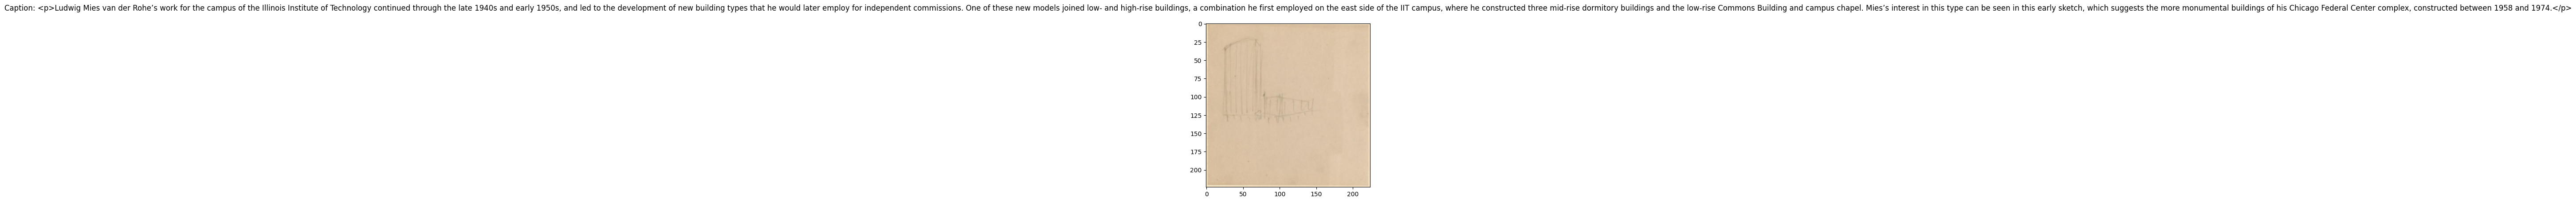

Process Process-6:
Process Process-7:
Process Process-5:
Process Process-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File 

In [26]:
import numpy as np
import matplotlib.pyplot as plt
# Create an iterator from the dataloader
data_iter = iter(clip_dataloader)

# Get one batch
batch = next(data_iter)


image = batch["image"][0]  # Assuming batch size is greater than 0
caption = batch["caption"][0]

# Convert the image tensor to a NumPy array and permute dimensions
image_np = np.transpose(image.numpy(), (1, 2, 0))

# Display the image and caption
plt.imshow(image_np)
plt.title(f"Caption: {caption}")
plt.show()

In [27]:
print("example of a caption in abatch:",  batch["caption"][0])
print("number of captions in each batch:",len(batch["caption"]))

example of a caption in abatch: <p>Ludwig Mies van der Rohe’s work for the campus of the Illinois Institute of Technology continued through the late 1940s and early 1950s, and led to the development of new building types that he would later employ for independent commissions. One of these new models joined low- and high-rise buildings, a combination he first employed on the east side of the IIT campus, where he constructed three mid-rise dormitory buildings and the low-rise Commons Building and campus chapel. Mies’s interest in this type can be seen in this early sketch, which suggests the more monumental buildings of his Chicago Federal Center complex, constructed between 1958 and 1974.</p>

number of captions in each batch: 128


In [7]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-nl4kd_x5
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-nl4kd_x5
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [28]:
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

def CLIP_loss(logits: torch.Tensor) -> torch.Tensor:
    # Assuming n is the number of classes
    n = logits.shape[1]

    # Create labels tensor
    labels = torch.arange(n).to(device)

    # Calculate cross entropy losses along axis 0 and 1
    loss_i = F.cross_entropy(logits.transpose(0, 1), labels, reduction="mean")
    loss_t = F.cross_entropy(logits, labels, reduction="mean")

    # Calculate the final loss
    loss = (loss_i + loss_t) / 2

    return loss

def metrics(similarity: torch.Tensor):
    y = torch.arange(len(similarity)).to(similarity.device)
    img2cap_match_idx = similarity.argmax(dim=1)
    cap2img_match_idx = similarity.argmax(dim=0)

    img_acc = (img2cap_match_idx == y).float().mean()
    cap_acc = (cap2img_match_idx == y).float().mean()

    return img_acc, cap_acc

In [29]:
import clip

# Load your model and preprocessing as usual
device = "cuda" # Example device, adjust as necessary
model, preprocess = clip.load("ViT-B/32", device=device)

# Assuming 'batch' is defined elsewhere
image = batch["image"].to(device)
true_text = batch["caption"]
wrong_text = true_text[::-1]

# Function to truncate tokens if necessary
def truncate_tokens(tokens, max_length):
    if tokens.shape[1] > max_length:
        return tokens[:, :max_length]
    return tokens

# Process captions
for captions in [true_text, wrong_text]:
    # Tokenize captions
    truncated_captions=[]
    for caption in captions:
        words = caption.split(" ")
        truncated_caption = ' '.join(words[:2])
        if '日' in truncated_caption:
            truncated_caption = ''
        truncated_captions.append(truncated_caption)
        
    tokens = clip.tokenize(truncated_captions).to(device)
    
    # Truncate tokens if necessary
#     tokens_truncated = truncate_tokens(tokens, 77)  # Example max length


    image_features = model.encode_image(image)
    text_features = model.encode_text(tokens)

    # Normalized features
    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)
    similarity = text_features @ image_features.T

    # Assume CLIP_loss is defined somewhere
    loss = CLIP_loss(similarity)
    print(loss)


tensor(4.8398, device='cuda:0', dtype=torch.float16, grad_fn=<DivBackward0>)
tensor(4.8555, device='cuda:0', dtype=torch.float16, grad_fn=<DivBackward0>)


In [30]:
from transformers import AutoModel, AutoTokenizer, BertTokenizer
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Projection(nn.Module):
    def __init__(self, d_in: int, d_out: int, p: float = 0.5) -> None:
        super().__init__()
        self.linear1 = nn.Linear(d_in, d_out, bias=False)
        self.linear2 = nn.Linear(d_out, d_out, bias=False)
        self.layer_norm = nn.LayerNorm(d_out)
        self.drop = nn.Dropout(p)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        embed1 = self.linear1(x)
        embed2 = self.drop(self.linear2(F.gelu(embed1)))
        embeds = self.layer_norm(embed1 + embed2)
        return embeds


class VisionEncoder(nn.Module):
    def __init__(self, d_out: int) -> None:
        super().__init__()
        base = models.resnet34(pretrained=True)
        d_in = base.fc.in_features
        base.fc = nn.Identity()
        self.base = base
        self.projection = Projection(d_in, d_out)
        for p in self.base.parameters():
            p.requires_grad = False

    def forward(self, x):
        projected_vec = self.projection(self.base(x))
        projection_len = torch.norm(projected_vec, dim=-1, keepdim=True)
        return projected_vec / projection_len


class TextEncoder(nn.Module):
    def __init__(self, d_out: int) -> None:
        super().__init__()
        self.base = AutoModel.from_pretrained(Config.text_model)
        self.projection = Projection(Config.transformer_embed_dim, d_out)
        for p in self.base.parameters():
            p.requires_grad = False

    def forward(self, x):
        out = self.base(x)[0]
        out = out[:, 0, :]  # get CLS token output
        projected_vec = self.projection(out)
        projection_len = torch.norm(projected_vec, dim=-1, keepdim=True)
        return projected_vec / projection_len
    
    


In [31]:
class Tokenizer:
    def __init__(self, tokenizer: BertTokenizer) -> None:
        self.tokenizer = tokenizer

    def __call__(self, x: str) -> AutoTokenizer:
        return self.tokenizer(
            x, max_length=Config.max_len, truncation=True, padding=True, return_tensors="pt"
        )


In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
image = batch["image"].to(device)
true_text = batch["caption"]
wrong_text = true_text[::-1]

vision_encoder = VisionEncoder(Config.embed_dim).to(device)
caption_encoder = TextEncoder(Config.embed_dim).to(device)
tokenizer = Tokenizer(AutoTokenizer.from_pretrained(Config.text_model))

for captions in [true_text, wrong_text]:
    text = tokenizer(captions).to(device)

    # with torch.no_grad():
    image_features = vision_encoder(image)
    text_features = caption_encoder(text["input_ids"])

    # normalized features
    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)
    similarity = text_features @ image_features.T
    loss = CLIP_loss(similarity)
    print(loss)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor(4.8507, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.8531, device='cuda:0', grad_fn=<DivBackward0>)


In [46]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from typing import List, Tuple


class CustomModel(nn.Module):
    def __init__(self, lr: float = 1e-4) -> None:
        super().__init__()
        self.vision_encoder = VisionEncoder(Config.embed_dim)
        self.caption_encoder = TextEncoder(Config.embed_dim)
        self.tokenizer = Tokenizer(AutoTokenizer.from_pretrained(Config.text_model, use_fast=False))
        self.lr = lr
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def forward(self, images, text):
        text = self.tokenizer(text).to(self.device)

        image_embed = self.vision_encoder(images)
        caption_embed = self.caption_encoder(text["input_ids"])
        similarity = caption_embed @ image_embed.T

        loss = CLIP_loss(similarity)
        img_acc, cap_acc = metrics(similarity)
        return loss, img_acc, cap_acc
    def get_similarity_matrix(self, images, text):
        """Compute the similarity matrix between images and captions."""
        text = self.tokenizer(text).to(self.device)

        # Get the embeddings
        image_embed = self.vision_encoder(images)
        caption_embed = self.caption_encoder(text["input_ids"])
        
        # Compute similarity matrix
        similarity = caption_embed @ image_embed.T
        
        return similarity



In [48]:
# Create an instance of your model
model = CustomModel().to(device)

In [49]:
model.load_state_dict(torch.load("/kaggle/working/model_weights.pth"))


<All keys matched successfully>

In [50]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_img_acc = 0
    total_cap_acc = 0
    with torch.no_grad():  # No need to track gradients for evaluation
        for batch in test_loader:
            images = batch["image"].to(device)
            captions = batch["caption"]
            
            # Forward pass
            loss, img_acc, cap_acc = model(images, captions)
            
            # Accumulate metrics
            total_loss += loss.item()
            total_img_acc += img_acc.item()
            total_cap_acc += cap_acc.item()
    
    # Calculate average metrics
    avg_loss = total_loss / len(test_loader)
    avg_img_acc = total_img_acc / len(test_loader)
    avg_cap_acc = total_cap_acc / len(test_loader)
    
    print(f"Test Loss: {avg_loss:.4f}, Image Accuracy: {avg_img_acc:.4f}, Caption Accuracy: {avg_cap_acc:.4f}")

# Assuming 'test_loader' is already defined and contains your test dataset
# Also assuming 'device' is defined (e.g., device = "cuda" if torch.cuda.is_available() else "cpu")
evaluate_model(model, test_loader, device)


Test Loss: 4.2580, Image Accuracy: 0.0832, Caption Accuracy: 0.0873


In [37]:
# Define optimizer
optimizer = torch.optim.Adam([
    {'params': model.vision_encoder.parameters()},
    {'params': model.caption_encoder.parameters()}
], lr=model.lr)


In [38]:
#TESTING WITH VALIDATION
start_epoch = 0
num_epochs = 10

for epoch in range(start_epoch, num_epochs):
    model.train()  # Set the model to training mode
    train_loss, train_img_acc, train_cap_acc = 0.0, 0.0, 0.0
    count = 0
    
    # Training Phase
    for batch in train_loader:
        count += 1
        image = batch["image"].to(device)
        text = batch["caption"]
        optimizer.zero_grad()  # Zero the gradients
        loss, img_acc, cap_acc = model(image, text)  # Forward pass
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        # Accumulate metrics
        train_loss += loss.item()
        train_img_acc += img_acc.item()
        train_cap_acc += cap_acc.item()
        
        if count % 100 == 0:
            print(f"Batch {count}, Training Loss: {loss.item()}")

    avg_train_loss = train_loss / count
    avg_train_img_acc = train_img_acc / count
    avg_train_cap_acc = train_cap_acc / count
    print(f"Epoch {epoch+1}, Average Training Loss: {avg_train_loss}, Image Acc: {avg_train_img_acc}, Caption Acc: {avg_train_cap_acc}")

    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    val_loss, val_img_acc, val_cap_acc = 0.0, 0.0, 0.0
    with torch.no_grad():  # No need to track gradients
        for batch in val_loader:
            image = batch["image"].to(device)
            text = batch["caption"]
            loss, img_acc, cap_acc = model(image, text)
            
            # Accumulate metrics
            val_loss += loss.item()
            val_img_acc += img_acc.item()
            val_cap_acc += cap_acc.item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_img_acc = val_img_acc / len(val_loader)
    avg_val_cap_acc = val_cap_acc / len(val_loader)
    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss}, Image Acc: {avg_val_img_acc}, Caption Acc: {avg_val_cap_acc}")

# After training is complete
print("Training complete.")

# Saving model weights
model_weights_path = "/kaggle/working/model_weights.pth"
torch.save(model.state_dict(), model_weights_path)


Epoch 1, Average Training Loss: 4.757415570996025, Image Acc: 0.03744476017626849, Caption Acc: 0.03886521472172304
Epoch 1, Validation Loss: 4.529399943351746, Image Acc: 0.052321428805589675, Caption Acc: 0.06116071492433548
Epoch 2, Average Training Loss: 4.610113935037092, Image Acc: 0.05786379426717758, Caption Acc: 0.059520991180430756
Epoch 2, Validation Loss: 4.430688905715942, Image Acc: 0.06741071492433548, Caption Acc: 0.07287946492433547
Epoch 3, Average Training Loss: 4.53965396230871, Image Acc: 0.06932607326995242, Caption Acc: 0.06484769572588531
Epoch 3, Validation Loss: 4.373811554908753, Image Acc: 0.07756696492433549, Caption Acc: 0.08017857149243354
Epoch 4, Average Training Loss: 4.491272709586403, Image Acc: 0.07169349762526425, Caption Acc: 0.08264283463358879
Epoch 4, Validation Loss: 4.334791278839111, Image Acc: 0.08198660761117935, Caption Acc: 0.08174107149243355
Epoch 5, Average Training Loss: 4.457862398841164, Image Acc: 0.07554056190631607, Caption Acc:

In [16]:
start_epoch = 0
num_epochs = 10

count = 0
batch_zero = True
for epoch in range(start_epoch, num_epochs):
    model.train()
    for batch in train_loader:
        count+=1
        if count%100==0:
            print(count)
        image = batch["image"].to(device)
        text = batch["caption"]
        # images, text = batch
        loss, img_acc, cap_acc = model(image, text)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_zero:
          print(f"Epoch [{0}/{num_epochs}], Batch Loss: {loss.item()}")
          batch_zero = False


    # Print training statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], Batch Loss: {loss.item()}")

print("Training complete.")
# Saving model weights after  training
model_weights_path = "/kaggle/working/model_weights_new.pth"
torch.save(model.state_dict(), model_weights_path)


Epoch [0/10], Batch Loss: 4.852419853210449
Epoch [1/10], Batch Loss: 3.9155640602111816
100
Epoch [2/10], Batch Loss: 3.8114914894104004
Epoch [3/10], Batch Loss: 3.76546049118042
200
Epoch [4/10], Batch Loss: 3.7404069900512695
Epoch [5/10], Batch Loss: 3.70747709274292
300
Epoch [6/10], Batch Loss: 3.6721816062927246
Epoch [7/10], Batch Loss: 3.634361982345581
400
Epoch [8/10], Batch Loss: 3.7320549488067627
Epoch [9/10], Batch Loss: 3.6907761096954346
500
Epoch [10/10], Batch Loss: 3.6509361267089844
Training complete.


In [17]:
import zipfile
with zipfile.ZipFile('/kaggle/working/weights.zip', 'w') as f:
    f.write('/kaggle/working/model_weights.pth')


In [20]:
# Assuming your model, device, and test_loader are already defined
model.eval()  # Set the model to evaluation mode

total_loss = 0
total_img_acc = 0
total_cap_acc = 0
count = 0

with torch.no_grad():  # No need to track gradients during evaluation
    for batch in test_loader:
        image = batch["image"].to(device)
        text = batch["caption"]
        truncated_captions=[]
        for caption in text:
            words = caption.split(" ")
            truncated_caption = ' '.join(words[:2])
            if '日' in truncated_caption:
                truncated_caption = ''
            truncated_captions.append(truncated_caption)
        # Tokenize the captions
        tokens = clip.tokenize(truncated_caption).to(device)
        
        # Get the features
        image_features = model.vision_encoder.encode_image(image)
        text_features = model.encode_text(tokens)
        
        # Normalize features
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)
        similarity = text_features @ image_features.T
        
        # Calculate loss and accuracy (assuming CLIP_loss and accuracy functions are defined)
        loss = CLIP_loss(similarity)
        img_acc, cap_acc = metrics(similarity)  # Assuming a metrics function that returns image and caption accuracy
        
        # Accumulate metrics
        total_loss += loss.item()
        total_img_acc += img_acc.item()
        total_cap_acc += cap_acc.item()
        count += 1

# Calculate average loss and accuracy
avg_loss = total_loss / count
avg_img_acc = total_img_acc / count
avg_cap_acc = total_cap_acc / count

print(f"Test Loss: {avg_loss:.4f}, Image Accuracy: {avg_img_acc:.4f}, Caption Accuracy: {avg_cap_acc:.4f}")


AttributeError: 'VisionEncoder' object has no attribute 'encode_image'

In [39]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_img_acc = 0
    total_cap_acc = 0
    with torch.no_grad():  # No need to track gradients for evaluation
        for batch in test_loader:
            images = batch["image"].to(device)
            captions = batch["caption"]
            
            # Forward pass
            loss, img_acc, cap_acc = model(images, captions)
            
            # Accumulate metrics
            total_loss += loss.item()
            total_img_acc += img_acc.item()
            total_cap_acc += cap_acc.item()
    
    # Calculate average metrics
    avg_loss = total_loss / len(test_loader)
    avg_img_acc = total_img_acc / len(test_loader)
    avg_cap_acc = total_cap_acc / len(test_loader)
    
    print(f"Test Loss: {avg_loss:.4f}, Image Accuracy: {avg_img_acc:.4f}, Caption Accuracy: {avg_cap_acc:.4f}")

# Assuming 'test_loader' is already defined and contains your test dataset
# Also assuming 'device' is defined (e.g., device = "cuda" if torch.cuda.is_available() else "cpu")
evaluate_model(model, test_loader, device)


Test Loss: 4.2580, Image Accuracy: 0.0832, Caption Accuracy: 0.0873


In [55]:
def top_k_accuracy(similarity, targets, k=10):
    """Calculate Top-K accuracy for image-caption matching."""
    top_k = similarity.topk(k=k, dim=1)[1]  # Get the indices of the top k values
    correct = top_k == targets.view(-1, 1).expand_as(top_k)
    top_k_acc = correct.any(dim=1).float().mean().item()
    return top_k_acc

def evaluate_model(model, test_loader, device, k=10):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0  # Assuming you might still want to track loss
    total_top_k_img_acc = 0
    total_top_k_cap_acc = 0
    
    with torch.no_grad():  # No need to track gradients for evaluation
        for batch in test_loader:
            images = batch["image"].to(device)
            captions = batch["caption"]
            # Assuming 'get_similarity_matrix' is a method that returns the similarity matrix
            similarity_matrix = model.get_similarity_matrix(images, captions)  # Adjusted line
            targets = torch.arange(len(similarity_matrix)).to(device)
            
            top_k_img_acc = top_k_accuracy(similarity_matrix, targets, k)
            top_k_cap_acc = top_k_accuracy(similarity_matrix.T, targets, k)  # Adjusted for caption to image
            
            # Assuming loss calculation is separate or not needed for this part
            # total_loss += loss.item()  # You would calculate loss elsewhere if needed
            
            # Accumulate Top-K accuracies
            total_top_k_img_acc += top_k_img_acc
            total_top_k_cap_acc += top_k_cap_acc
    
    # Calculate average metrics
    avg_top_k_img_acc = total_top_k_img_acc / len(test_loader)
    avg_top_k_cap_acc = total_top_k_cap_acc / len(test_loader)
    
    print(f"Test Top-{k} Image Accuracy: {avg_top_k_img_acc:.4f}, Test Top-{k} Caption Accuracy: {avg_top_k_cap_acc:.4f}")

# You would need to ensure 'get_similarity_matrix' or equivalent functionality is implemented in your model.

# Call the evaluation function with Top-K accuracy calculation
evaluate_model(model, test_loader, device, k=10)


Test Top-10 Image Accuracy: 0.4769, Test Top-10 Caption Accuracy: 0.4830
